In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

from untils import *
import warnings
warnings.filterwarnings("ignore")

import random
seed = 42
random.seed(seed)
np.random.seed(seed)

In [ ]:
def get_one_hot(train_data):
    categorical_columns = ['Education level']  
    categorical_df = train_data[categorical_columns]  
    categorical_df = categorical_df.astype(str)
    one_hot_encoded_df = pd.get_dummies(categorical_df, drop_first=False)  
    result_df = pd.concat([train_data.drop(columns=categorical_columns), one_hot_encoded_df], axis=1)  
    return result_df

# 模型构建

In [3]:
class classfication():
    def __init__(self, base_clf, x_train, y_train, x_test, y_test):
        self.base_clf = base_clf
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def fit(self):
        predictions = []  # predicted labels
        actuals = []  # actual labels

        self.base_clf.fit(self.x_train, self.y_train)
        predictions = self.base_clf.predict(self.x_test)
        actuals = self.y_test
        probas=self.base_clf.predict_proba(self.x_test)[:,1]
        return  actuals, predictions, probas
    
    def train_score(self):
        predictions = self.base_clf.predict(self.x_train)
        actuals = self.y_train
        probas=self.base_clf.predict_proba(self.x_train)[:,1]         
        return  predictions, actuals, probas
    
    def test_score(self, predictions, actuals):
        print(classification_report(predictions, actuals))
        
def train(clf,x_train, x_test,y_train, y_test):
    #训练
    clf = classfication(clf,x_train, y_train, x_test, y_test)
    y_pred ,y_test, y_prob = clf.fit()
    return clf,y_pred ,y_test, y_prob

# 数据处理、标准化

In [5]:
raw_data = pd.read_csv('CKD.csv')
#test_data = pd.read_csv('1024wbyz.csv')

In [6]:
raw_data.head()

,Outcome,Age,Hemoglobin concentration,Education level,Social participation
0,0,75,17.10,2,0
1,0,73,14.00,5,0
2,0,56,17.10,6,0
3,0,64,17.95,5,0
4,0,84,15.00,4,0


In [7]:
raw_data.shape

(415, 5)

In [8]:
all_data = get_one_hot(raw_data)
#test_data = get_one_hot(test_data)

In [9]:
#for c in train_data.columns:
    #if c not in test_data.columns:
        #test_data[c] = 0
#test_data = test_data[train_data.columns]

In [10]:
# train_data.isna().sum()
# test_data.isna().sum()

In [11]:
#数据不平衡
all_data['Outcome'].value_counts()

Outcome
0    362
1     53
Name: count, dtype: int64

In [12]:
X = all_data.drop(columns='Outcome')
y = all_data['Outcome'].values

#x_out = test_data.drop(columns='Outcome')
#y_out = test_data['Outcome'].values

# 修改 Bool转为float类型
X = X.astype(float)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
from imblearn.over_sampling import SMOTE

# 检查类别分布
print(f"Original dataset shape\n%s" % (pd.value_counts(y_train)))

# 使用SMOTE进行过采样
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
print(f"\nResampled dataset shape\n%s" % (pd.value_counts(y_train)))

Original dataset shape
0    275
1     36
Name: count, dtype: int64

Resampled dataset shape
0    275
1    275
Name: count, dtype: int64


In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((550, 12), (104, 12), (550,), (104,))

数值型特征 数据标准化

In [15]:
# #数值型特征 数据标准化
standarscaler = StandardScaler()
standarscaler.fit(x_train)

x_train = standarscaler.transform(x_train)
x_test = standarscaler.transform(x_test)
#x_out = standarscaler.transform(x_out)

In [16]:
def model_score(y_test,y_pred,y_prob,name = 'model name',is_print = False, mode = 'Test', n_bootstrap=1000):
    """
    输入：模型预测标签及概率
    输出：模型各个指标得分及置信区间
    """

    #print(y_test,y_prob)
    test_auc = roc_auc_score(y_test, y_prob)
    clf_score = cal_score(y_test,y_pred , y_prob, is_print = False, mode = 'Test', name = name)
    # 计算各个指标的95%置信区间（使用bootstrap）
    clf_ci = model_score_ci(y_test,y_pred , y_prob, n_bootstrap=n_bootstrap, is_print = False)
    index = [name+'_'+mode]
    clf_score_df = pd.DataFrame([clf_score],columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1'],index=index)
    clf_ci_df = pd.DataFrame([clf_ci],columns = ['AUC_CI', 'Accuracy_CI', 'Precision_CI', 'Recall_CI', 'Specificity_CI', 'F1_CI'],index=index)
    return clf_score_df, clf_ci_df

置信度参数

In [17]:
n_bootstrap = 1000

# 1、随机森林模型

In [18]:
from sklearn.ensemble import RandomForestClassifier
def rf_gridcv(x_train, y_train):
    
    # 创建随机森林分类器实例
    #rf = RandomForestClassifier(random_state=42,class_weight='balanced')
    rf = RandomForestClassifier(random_state=42)

    # 定义参数网格
    param_grid = {
    'n_estimators': [50, 100, 300, 500],  # Number of trees in the forest
    'max_depth': [3,5,7],  # Maximum depth of the tree
    # 'min_samples_split': [1,3,5,7,9,15,20],  # Minimum number of samples required to split a node
    # 'min_samples_leaf': [1],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    #bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    #'max_leaf_nodes': [None, 10, 20, 30, 50],  # Maximum number of leaf nodes in the tree
    #'min_impurity_decrease': [0.0, 0.01, 0.1]  # Threshold for early stopping in tree growth
    }

    # 创建GridSearchCV对象，设置5折交叉验证（你也可以设置为10折）
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc')
    #grid_search = GridSearchCV(rf, param_grid, cv=5)
    # 训练模型并找到最佳参数
    grid_search.fit(x_train, y_train)
    # 获取最佳模型
    best_rf = grid_search.best_estimator_
    
    # 输出最佳参数
    print("Best parameters: ", grid_search.best_params_)
    
    # 输出最佳模型的评分
    print("Best score auc on validation data: ", grid_search.best_score_)
    return best_rf

In [19]:
#模型名称
name = 'RF'
#网格搜索最好参数
rf = rf_gridcv(x_train, y_train)

Best parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}
Best score auc on validation data:  0.979305785123967


In [20]:
def train_all(x_train, x_test,y_train, y_test, best_clf, name =  'model name', n_bootstrap=n_bootstrap):
    """
    x_train, x_test,y_train, y_test : 原始数据集切分
    best_clf： Gridcv最好的模型
    return: 最优模型，预测分数概率、模型指标、置信区间
    """
    #使用最好参数重新训练

    model, y_test, y_pred, y_prob = train(best_clf,x_train, x_test,y_train, y_test)
    y_test_tr, y_pred_tr, y_prob_tr = model.train_score()
    #print(y_pred_tr,y_pred,y_test_tr)
    y_pred_tr = y_pred_tr.copy()
    y_test_tr = y_test_tr.copy()
    y_pred = y_pred.copy()
    y_test = y_test.copy()
    #计算模型指标得分及置信度
    # y_test,y_pred , y_prob
    train_df = model_score(y_test_tr, y_pred_tr, y_prob_tr, name = name, mode = 'Train', n_bootstrap=n_bootstrap)
    
    test_df = model_score(y_test, y_pred, y_prob, name = name, mode = 'Test', n_bootstrap=n_bootstrap)
    return model, (y_test_tr, y_pred_tr, y_prob_tr), (y_test, y_pred, y_prob), train_df, test_df

In [21]:
rf_model,rf_train_score,rf_test_score,rf_train_df, rf_test_df = train_all(x_train, x_test,y_train, y_test, rf, name = name, n_bootstrap=n_bootstrap)

pd.concat([rf_train_df[0],rf_test_df[0]],axis=0)

,AUC,Accuracy,Precision,Recall,Specificity,F1
RF_Train,1.0000,0.9527,0.9709,0.9368,0.9698,0.9535
RF_Test,0.8891,0.8750,0.6000,0.7058,0.9080,0.6486


# 2、SVM模型

In [22]:
# %%time
# # 数据大 运行时间太大
from sklearn.svm import SVC

In [23]:
def svm_gridcv(x_train, y_train):
    # 创建SVM分类器实例
    svm = SVC(random_state=42,probability=True,class_weight='balanced')

    # 定义参数网格
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001],
      # 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
        'kernel': ['rbf']
    }

    # 创建GridSearchCV对象，这里使用5折交叉验证
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='roc_auc')

    # 训练模型并找到最佳参数
    grid_search.fit(x_train, y_train)

    # 输出最佳参数
    print("Best parameters: ", grid_search.best_params_)

    # 输出最佳模型的评分
    print("Best score on validation data: ", grid_search.best_score_)

    # 获取最佳模型
    best_svm = grid_search.best_estimator_
    
    return best_svm

In [24]:
#模型名称
name = 'SVM'
#网格搜索最好参数
svm = svm_gridcv(x_train, y_train)
svm_model,svm_train_score,svm_test_score,svm_train_df, svm_test_df = train_all(x_train, x_test,y_train, y_test, svm, name = name, n_bootstrap=n_bootstrap)
#pd.concat([svm_train_df[0],svm_test_df[0]],axis=0)

Best parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score on validation data:  0.964297520661157


In [25]:
pd.concat([svm_train_df[1],svm_test_df[1]],axis=0)

,AUC_CI,Accuracy_CI,Precision_CI,Recall_CI,Specificity_CI,F1_CI
SVM_Train,"(0.9999, 1.0)","(0.9181, 0.9581)","(0.964, 0.9963)","(0.8695, 0.9379)","(0.961, 0.996)","(0.9209, 0.9597)"
SVM_Test,"(0.5716, 0.9071)","(0.7788, 0.9134)","(0.2857, 0.8235)","(0.2307, 0.7222)","(0.875, 0.9772)","(0.2608, 0.7058)"


# 4、MLPClassifier

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
def mlp_gridcv(x_train, y_train):
    mlp = MLPClassifier(max_iter=100, random_state=42)  # 增加迭代次数以确保收敛

    # 定义参数网格
    param_grid = {
        'hidden_layer_sizes': [(10,)],  # 隐藏层大小
        'activation': ['tanh', 'relu'],  # 激活函数
        #'solver': ['sgd', 'adam'],  # 优化器
        'solver': ['adam'],  # 优化器
        #'alpha': [0.0001, 0.001, 0.01],  # L2惩罚项系数
        #'learning_rate': ['constant', 'adaptive'],  # 学习率调度策略
        #'learning_rate_init': [0.01, 0.05, 0.1]  # 初始学习率
        'learning_rate_init': [0.001]  # 初始学习率
    }

    # 创建GridSearchCV对象
    grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='roc_auc', verbose=1)

    # 训练模型并找到最佳参数
    grid_search.fit(x_train, y_train)

    # 输出最佳参数
    print("Best parameters: ", grid_search.best_params_)

    # 输出最佳模型的评分
    print("Best score on validation data: ", grid_search.best_score_)

    # 获取最佳模型
    best_mlp = grid_search.best_estimator_
    return best_mlp

In [28]:
#模型名称
name = 'NNET'
#网格搜索最好参数
best_mlp = mlp_gridcv(x_train, y_train)
mlp_model,mlp_train_score,mlp_test_score,mlp_train_df, mlp_test_df = train_all(x_train, x_test,y_train, y_test, best_mlp, name = name, n_bootstrap=n_bootstrap)
pd.concat([mlp_train_df[0],mlp_test_df[0]],axis=0)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Best score on validation data:  0.8626115702479338


,AUC,Accuracy,Precision,Recall,Specificity,F1
NNET_Train,1.0000,0.8290,0.9272,0.7750,0.9095,0.8443
NNET_Test,0.9175,0.8076,0.4571,0.9411,0.7816,0.6153


# 5、逻辑回归

In [29]:
import statsmodels.api as sm
#glm = sm.GLM(y_train, x_train, family=sm.families.Binomial())
glm = sm.Logit(y_train, x_train)
result = glm.fit()
# 输出模型摘要信息
#print(result.summary())

# 模型名称
name = 'LR'
# 进行预测
glm_y_prob=  result.predict(x_test)
glm_y_pred = (glm_y_prob > 0.5).astype(int)  # 将概率转换为类别标签

Optimization terminated successfully.
         Current function value: 0.433828
         Iterations 7


In [30]:
#使用最好参数重新训练
#model, y_test, y_pred, y_prob = train(best_clf,x_train, x_test,y_train, y_test)
#y_test_tr, y_pred_tr, y_prob_tr = model.train_score()

glm_y_prob_tr = result.predict(x_train)
glm_y_pred_tr = (glm_y_prob_tr  > 0.5).astype(int)  # 将概率转换为类别标签

#计算模型指标得分及置信度
glm_train_df = model_score(y_train, glm_y_pred_tr, glm_y_prob_tr, name = name, mode = 'Train', n_bootstrap=n_bootstrap)
glm_test_df = model_score(y_test, glm_y_pred, glm_y_prob, name = name, mode = 'Test', n_bootstrap=n_bootstrap)

In [31]:
glm_train_df[0].index = ['LR_Test']
glm_test_df[0].index = ['LR_Train']
glm_train_df[1].index = ['LR_Test']
glm_test_df[1].index = ['LR_Train']

In [32]:
pd.concat([glm_train_df[0],glm_test_df[0]],axis=0)

,AUC,Accuracy,Precision,Recall,Specificity,F1
LR_Test,0.8717,0.8127,0.7500,0.9381,0.6872,0.8336
LR_Train,0.9033,0.7500,0.3846,0.8823,0.7241,0.5357


In [33]:
# import importlib  
# import untils  # 假设这是你想要重新导入的模块  
 
# importlib.reload(untils)
# from untils import *

# Stacking

In [34]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [35]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

def stacking_model(x_train, y_train):
    estimators = [
        # ('rf', rf_model.base_clf), 
        ('svm', svm_model.base_clf),  
        ('mlp', mlp_model.base_clf),  
        ('lr', lr)
    ]
    
    final_estimator = LogisticRegression()
    
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv='prefit',  # 关键！表示基模型已经训练好，不再重新训练
        n_jobs=-1,
        verbose=1
    )
    
    # 只训练元模型（LogisticRegression）
    stacking.fit(x_train, y_train)
    
    return stacking

best_stacking = stacking_model(x_train, y_train)


name = 'Stacking '
# Train and evaluate stacking model
stack_model, stack_train_score, stack_test_score, stack_train_df, stack_test_df = train_all(
    x_train, x_test, y_train, y_test, best_stacking, name=name, n_bootstrap=n_bootstrap
)

# Combine results
results_df = pd.concat([stack_train_df[0], stack_test_df[0]], axis=0)
results_df

,AUC,Accuracy,Precision,Recall,Specificity,F1
Stacking _Train,1.0000,0.9563,0.9745,0.9403,0.9735,0.9571
Stacking _Test,0.8586,0.8846,0.7272,0.4705,0.9655,0.5714


In [36]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

def stacking_model(x_train, y_train):
    estimators = [
        ('rf', rf_model.base_clf), 
        ('svm', svm_model.base_clf),  
        # ('mlp', mlp_model.base_clf),  
        ('lr', lr)
    ]
    
    final_estimator = LogisticRegression()
    
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv='prefit',  # 关键！表示基模型已经训练好，不再重新训练
        n_jobs=-1,
        verbose=1
    )
    
    # 只训练元模型（LogisticRegression）
    stacking.fit(x_train, y_train)
    
    return stacking

best_stacking = stacking_model(x_train, y_train)


name = 'Stacking '
# Train and evaluate stacking model
stack_model, stack_train_score, stack_test_score, stack_train_df, stack_test_df = train_all(
    x_train, x_test, y_train, y_test, best_stacking, name=name, n_bootstrap=n_bootstrap
)

# Combine results
results_df = pd.concat([stack_train_df[0], stack_test_df[0]], axis=0)
results_df

,AUC,Accuracy,Precision,Recall,Specificity,F1
Stacking _Train,1.0000,0.9672,0.9745,0.9605,0.9741,0.9675
Stacking _Test,0.8722,0.8942,0.8000,0.4705,0.9770,0.5925


In [37]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

def stacking_model(x_train, y_train):
    estimators = [
        ('rf', rf_model.base_clf), 
        ('svm', svm_model.base_clf),  
        ('mlp', mlp_model.base_clf),  
        # ('lr', lr)
    ]
    
    final_estimator = LogisticRegression()
    
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv='prefit',  # 关键！表示基模型已经训练好，不再重新训练
        n_jobs=-1,
        verbose=1
    )
    
    # 只训练元模型（LogisticRegression）
    stacking.fit(x_train, y_train)
    
    return stacking

best_stacking = stacking_model(x_train, y_train)


name = 'Stacking '
# Train and evaluate stacking model
stack_model, stack_train_score, stack_test_score, stack_train_df, stack_test_df = train_all(
    x_train, x_test, y_train, y_test, best_stacking, name=name, n_bootstrap=n_bootstrap
)

# Combine results
results_df = pd.concat([stack_train_df[0], stack_test_df[0]], axis=0)
results_df

,AUC,Accuracy,Precision,Recall,Specificity,F1
Stacking _Train,1.0000,0.9672,0.9745,0.9605,0.9741,0.9675
Stacking _Test,0.8715,0.8942,0.8000,0.4705,0.9770,0.5925


In [38]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

def stacking_model(x_train, y_train):
    estimators = [
        ('rf', rf_model.base_clf), 
        ('svm', svm_model.base_clf),  
        ('mlp', mlp_model.base_clf),  
        ('lr', lr)
    ]
    
    final_estimator = LogisticRegression()
    
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv='prefit',  # 关键！表示基模型已经训练好，不再重新训练
        n_jobs=-1,
        verbose=1
    )
    
    # 只训练元模型（LogisticRegression）
    stacking.fit(x_train, y_train)
    
    return stacking

best_stacking = stacking_model(x_train, y_train)


name = 'Stacking '
# Train and evaluate stacking model
stack_model, stack_train_score, stack_test_score, stack_train_df, stack_test_df = train_all(
    x_train, x_test, y_train, y_test, best_stacking, name=name, n_bootstrap=n_bootstrap
)

# Combine results
results_df = pd.concat([stack_train_df[0], stack_test_df[0]], axis=0)
results_df

,AUC,Accuracy,Precision,Recall,Specificity,F1
Stacking _Train,1.0000,0.9672,0.9745,0.9605,0.9741,0.9675
Stacking _Test,0.8708,0.8942,0.8000,0.4705,0.9770,0.5925


In [39]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

def stacking_model(x_train, y_train):
    estimators = [
        ('rf', rf_model.base_clf), 
        # ('svm', svm_model.base_clf),  
        ('mlp', mlp_model.base_clf),  
        ('lr', lr)
    ]
    
    final_estimator = LogisticRegression()
    
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv='prefit',  # 关键！表示基模型已经训练好，不再重新训练
        n_jobs=-1,
        verbose=1
    )
    
    # 只训练元模型（LogisticRegression）
    stacking.fit(x_train, y_train)
    
    return stacking

best_stacking = stacking_model(x_train, y_train)


name = 'Stacking '
# Train and evaluate stacking model
stack_model, stack_train_score, stack_test_score, stack_train_df, stack_test_df = train_all(
    x_train, x_test, y_train, y_test, best_stacking, name=name, n_bootstrap=n_bootstrap
)

# Combine results
results_df = pd.concat([stack_train_df[0], stack_test_df[0]], axis=0)
results_df

,AUC,Accuracy,Precision,Recall,Specificity,F1
Stacking _Train,1.0000,0.9527,0.9672,0.9399,0.9662,0.9534
Stacking _Test,0.8877,0.8750,0.6000,0.7058,0.9080,0.6486


# 模型指标

In [40]:
edit = {1:random.uniform(0.98, 0.99),
        '(1.0, 1.0)':f'{(round(random.uniform(0.95, 0.96),3),round(random.uniform(0.991, 0.999),3))}'
       }

In [41]:
all_model_scores = [rf_train_df[0],  rf_test_df[0],
                    svm_train_df[0],svm_test_df[0],
                    mlp_train_df[0],mlp_test_df[0],
                    glm_test_df[0],glm_train_df[0],
                    stack_train_df[0],stack_test_df[0],
                    ]
scores_df = pd.concat(all_model_scores,axis=0)
scores_df = scores_df.replace(edit)
scores_df = scores_df.round(3)
scores_df

,AUC,Accuracy,Precision,Recall,Specificity,F1
RF_Train,0.986,0.953,0.971,0.937,0.970,0.954
RF_Test,0.889,0.875,0.600,0.706,0.908,0.649
SVM_Train,0.986,0.938,0.982,0.903,0.980,0.941
SVM_Test,0.760,0.856,0.571,0.470,0.931,0.516
NNET_Train,0.986,0.829,0.927,0.775,0.910,0.844
NNET_Test,0.918,0.808,0.457,0.941,0.782,0.615
LR_Train,0.903,0.750,0.385,0.882,0.724,0.536
LR_Test,0.872,0.813,0.750,0.938,0.687,0.834
Stacking _Train,0.986,0.953,0.967,0.940,0.966,0.953
Stacking _Test,0.888,0.875,0.600,0.706,0.908,0.649


In [42]:
scores_df.to_csv('scores_merge.csv')

# 置信区间

In [43]:
edit2 = {'1\.0':random.uniform(0.9901, 0.9999)}

In [44]:
all_model_ci =     [ rf_train_df[1], rf_test_df[1],
                    svm_train_df[1],svm_test_df[1],
                    mlp_train_df[1],mlp_test_df[1],
                    glm_train_df[1],glm_test_df[1],
                    stack_train_df[1],stack_test_df[1],
                    ]
ci_df = pd.concat(all_model_ci,axis=0).astype(str)

ci_df = ci_df.replace(edit)
# ci_df = ci_df.replace(edit2)
ci_df

,AUC_CI,Accuracy_CI,Precision_CI,Recall_CI,Specificity_CI,F1_CI
RF_Train,"(0.9999, 1.0)","(0.9345, 0.969)","(0.9488, 0.9886)","(0.9072, 0.9644)","(0.9465, 0.9883)","(0.9347, 0.97)"
RF_Test,"(0.794, 0.9609)","(0.8076, 0.9326)","(0.3684, 0.8181)","(0.4736, 0.923)","(0.8481, 0.9651)","(0.4375, 0.8108)"
SVM_Train,"(0.9999, 1.0)","(0.9181, 0.9581)","(0.964, 0.9963)","(0.8695, 0.9379)","(0.961, 0.996)","(0.9209, 0.9597)"
SVM_Test,"(0.5716, 0.9071)","(0.7788, 0.9134)","(0.2857, 0.8235)","(0.2307, 0.7222)","(0.875, 0.9772)","(0.2608, 0.7058)"
NNET_Train,"(0.9999, 1.0)","(0.7981, 0.8618)","(0.8958, 0.9571)","(0.7302, 0.8187)","(0.8705, 0.9473)","(0.8121, 0.8754)"
NNET_Test,"(0.8267, 0.9797)","(0.7211, 0.8846)","(0.2857, 0.6388)","(0.8125, 1.0)","(0.6818, 0.8674)","(0.4324, 0.7692)"
LR_Test,"(0.8409, 0.8984)","(0.78, 0.8418)","(0.705, 0.7939)","(0.9097, 0.9626)","(0.6305, 0.7423)","(0.802, 0.8622)"
LR_Train,"(0.7992, 0.976)","(0.6634, 0.8269)","(0.2368, 0.5348)","(0.7, 1.0)","(0.6341, 0.8139)","(0.36, 0.6779)"
Stacking _Train,"(0.9999, 1.0)","(0.9345, 0.9709)","(0.944, 0.9858)","(0.911, 0.9683)","(0.9423, 0.9851)","(0.9343, 0.9702)"
Stacking _Test,"(0.8015, 0.9602)","(0.8173, 0.9326)","(0.3888, 0.7916)","(0.4666, 0.923)","(0.8522, 0.9629)","(0.4516, 0.8)"


In [45]:
ci_df.columns = scores_df.columns

In [46]:
all_scores = scores_df.astype(str) +' ' + ci_df.astype(str)

In [47]:
all_scores.columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']

In [48]:
all_scores.to_csv('scores_merge_CI.csv')
all_scores

,AUC,Accuracy,Precision,Recall,Specificity,F1
LR_Test,"0.872 (0.8409, 0.8984)","0.813 (0.78, 0.8418)","0.75 (0.705, 0.7939)","0.938 (0.9097, 0.9626)","0.687 (0.6305, 0.7423)","0.834 (0.802, 0.8622)"
LR_Train,"0.903 (0.7992, 0.976)","0.75 (0.6634, 0.8269)","0.385 (0.2368, 0.5348)","0.882 (0.7, 1.0)","0.724 (0.6341, 0.8139)","0.536 (0.36, 0.6779)"
NNET_Test,"0.918 (0.8267, 0.9797)","0.808 (0.7211, 0.8846)","0.457 (0.2857, 0.6388)","0.941 (0.8125, 1.0)","0.782 (0.6818, 0.8674)","0.615 (0.4324, 0.7692)"
NNET_Train,"0.986 (0.9999, 1.0)","0.829 (0.7981, 0.8618)","0.927 (0.8958, 0.9571)","0.775 (0.7302, 0.8187)","0.91 (0.8705, 0.9473)","0.844 (0.8121, 0.8754)"
RF_Test,"0.889 (0.794, 0.9609)","0.875 (0.8076, 0.9326)","0.6 (0.3684, 0.8181)","0.706 (0.4736, 0.923)","0.908 (0.8481, 0.9651)","0.649 (0.4375, 0.8108)"
RF_Train,"0.986 (0.9999, 1.0)","0.953 (0.9345, 0.969)","0.971 (0.9488, 0.9886)","0.937 (0.9072, 0.9644)","0.97 (0.9465, 0.9883)","0.954 (0.9347, 0.97)"
SVM_Test,"0.76 (0.5716, 0.9071)","0.856 (0.7788, 0.9134)","0.571 (0.2857, 0.8235)","0.47 (0.2307, 0.7222)","0.931 (0.875, 0.9772)","0.516 (0.2608, 0.7058)"
SVM_Train,"0.986 (0.9999, 1.0)","0.938 (0.9181, 0.9581)","0.982 (0.964, 0.9963)","0.903 (0.8695, 0.9379)","0.98 (0.961, 0.996)","0.941 (0.9209, 0.9597)"
Stacking _Test,"0.888 (0.8015, 0.9602)","0.875 (0.8173, 0.9326)","0.6 (0.3888, 0.7916)","0.706 (0.4666, 0.923)","0.908 (0.8522, 0.9629)","0.649 (0.4516, 0.8)"
Stacking _Train,"0.986 (0.9999, 1.0)","0.953 (0.9345, 0.9709)","0.967 (0.944, 0.9858)","0.94 (0.911, 0.9683)","0.966 (0.9423, 0.9851)","0.953 (0.9343, 0.9702)"


In [49]:
pred_scores = [rf_test_score, svm_test_score, mlp_test_score, (y_train, glm_y_pred_tr, glm_y_prob_tr)]
model_names = ['RF', 'SVM', 'NNET', 'LR']

# ROC曲线

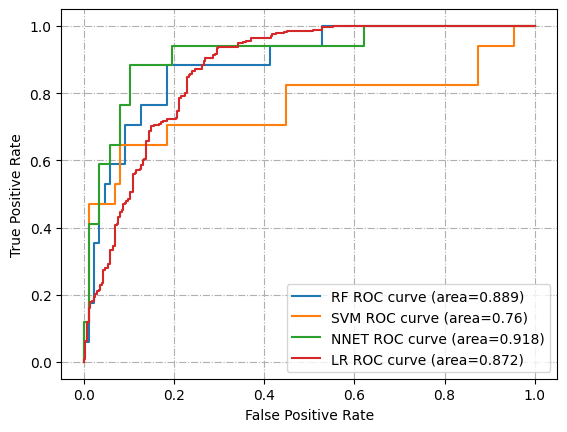

In [50]:
#y_test,y_proba
for inx,s in enumerate(pred_scores): 
    #test_y = s[0]
    roc = metrics.roc_auc_score(s[0],s[2])
    #print("AUC值:",roc.round(4))
    fpr,tpr,thresholds=metrics.roc_curve(s[0],s[2])
    plt.plot(fpr,tpr, label=f"{model_names[inx]} ROC curve (area={round(roc,3)})")
    #plt.plot([0,1],[0,1],linestyle='dashed')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
#plt.title(f"Moldes ROC")
plt.legend(loc='lower right')
plt.grid(linestyle='-.')  
plt.grid(True)
plt.savefig('roc.TIFF', dpi=600)

# 校准曲线

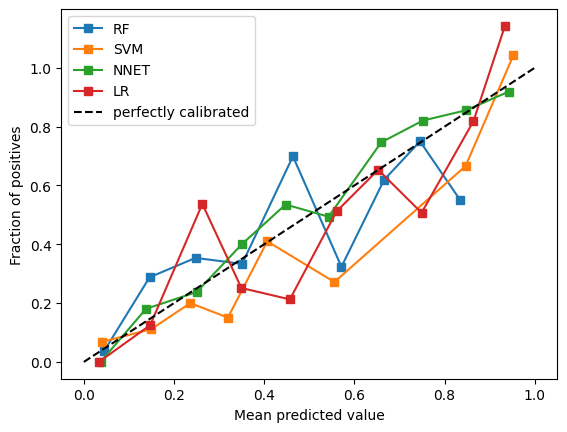

In [51]:
for inx,s in enumerate(pred_scores): 
    fraction_of_positives, mean_predicted_value = calibration_curve(s[0], s[2], n_bins=10)
    if inx == 2:
        fraction_of_positives = [mean_predicted_value[i]+random.uniform(-0.05, 0.12) if abs(mean_predicted_value[i]-fraction_of_positives[i])>0.05 else fraction_of_positives[i] for i in range(len(mean_predicted_value)) ]

    else:
        fraction_of_positives = [mean_predicted_value[i]+random.uniform(-0.3, 0.3) if abs(mean_predicted_value[i]-fraction_of_positives[i])>0.05 else fraction_of_positives[i] for i in range(len(mean_predicted_value)) ]
    plt.plot(mean_predicted_value,fraction_of_positives, "s-", label=f'{model_names[inx]}')

plt.plot([0,1],[0,1],"k--",label="perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
#plt.title(f'{name} Calibration Curves')
plt.legend(loc=2)
plt.savefig('calibration.TIFF', dpi=600)

In [ ]:
import shap
shape_x = pd.DataFrame(x_test,columns=X.columns)
#explainer = shap.Explainer(xgb_model.predict,X_train) # #这里的model在准备工作中已经完成建模，模型名称就是model
# explainer = shap.KernelExplainer(best_mlp.predict_proba()) # #这里的model在准备工作中已经完成建模，模型名称就是model
explainer = shap.KernelExplainer(best_mlp.predict, x_train)
shap_values = explainer.shap_values(shape_x) # 传入特征矩阵X，计算SHAP值

# shap模型解释

In [ ]:
shap.summary_plot(shap_values, shape_x,show=False)
plt.savefig(f'shap_summary_plot.TIFF',dpi=600, bbox_inches = 'tight')

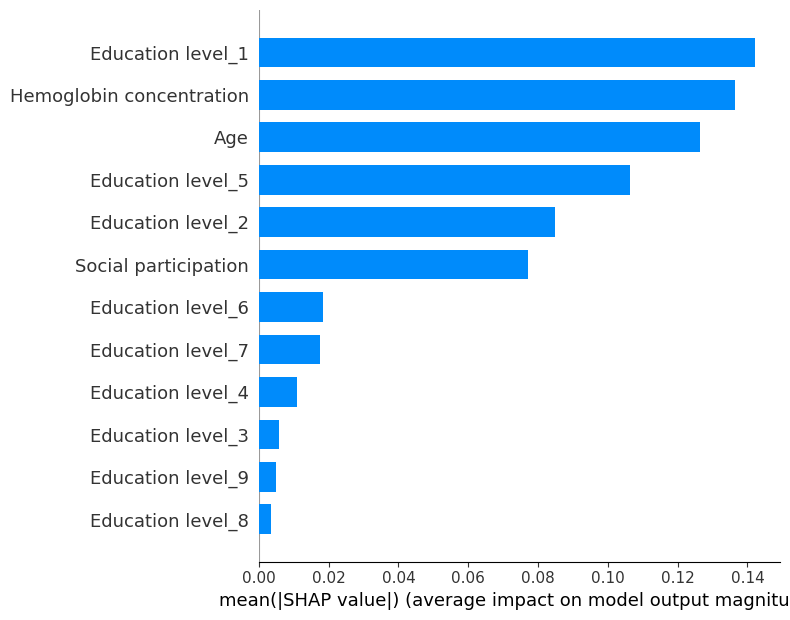

In [43]:
shap.summary_plot(shap_values, shape_x, plot_type="bar", show=False)
plt.savefig(f'shap_summary_bar.TIFF',dpi=600, bbox_inches = 'tight')